In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np
import re

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modeling - Logistic, XGBOOST, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
import sys
sys.path.append(f'../../src/python')

from balance_split_data import create_label, retain_section, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../data/processed/pre-processed_merged_2023_04_04.json")

In [4]:
# Define a regular expression pattern to match the unwanted words
remove_words = ['dg comp merger registry', 'belgië', 'tel fax mail', 'tel', 'fax', 'comp merger registry',
                'ec europa eu', 'belgië fax', 'comp merger registry', 'tel', 'tel fax', 'fax mail', 'registry fax']
remove_pattern = re.compile(r'\b(' + '|'.join(remove_words) + r')\b', flags=re.IGNORECASE)
df['text_clean'] = df['text_clean'].replace(remove_pattern, '', regex=True)

#### Loop creation of train and test sets by section

In [5]:
label_name = "wc"
section_dict={0:'Parties & Operation', 1:'Concentration & Dimension', 
              2:'Market Definition', 3:'Competitive Assessment'}
random_seed=42
random_state=42

In [6]:
# Loop by section and WC
for section_key in section_dict.keys():
    df1 = create_label(df, label_name)
    df1 = retain_section(df1, section=section_dict[section_key])
    print(df1['section_fin'].value_counts())
    df_unique = balance_unique_id(df1)
    df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=random_seed)
    df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=random_state)
    globals()[f"df_train_grouped_{section_key}"], globals()[f"df_test_grouped_{section_key}"], \
    globals()[f"df_test1_grouped_{section_key}"], globals()[f"df_excluded_grouped_{section_key}"] = group_by_case(df_train, df_test, df_test1, df_excluded)

    globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], globals()[f"X_test_{section_key}"], globals()[f"y_test_{section_key}"], \
    globals()[f"X_test1_{section_key}"], globals()[f"y_test1_{section_key}"], globals()[f"X_test2_{section_key}"], globals()[f"y_test2_{section_key}"] = create_feature_label(globals()[f"df_train_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_test_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_test1_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_excluded_grouped_{section_key}"])

Parties & Operation    1436
Name: section_fin, dtype: int64
Total decisions: 1435
0    1219
1     216
Name: label, dtype: int64
Balancing...
Total decisions: 432
Labels distribution: 
 0    216
1    216
Name: 0, dtype: int64
Training set shape: (345,) (345,)
Test set shape: (87,) (87,)
Creating df_train 1: 172 0: 173
Creating df_test1 1: 44 0: 43
Creating df_test concatenated with df_excluded with len: 1003
Creating df_test 1: 44 0: 1046
Grouping df_train by case_num 1: 172 0: 173
Grouping df_test by case_num 1: 44 0: 1046
Grouping df_test1 by case_num 1: 44 0: 43
Grouping df_excluded by case_num with len: 1003
Concentration & Dimension    1532
Name: section_fin, dtype: int64
Total decisions: 1532
0    1294
1     238
Name: label, dtype: int64
Balancing...
Total decisions: 476
Labels distribution: 
 1    238
0    238
Name: 0, dtype: int64
Training set shape: (380,) (380,)
Test set shape: (96,) (96,)
Creating df_train 1: 189 0: 190
Creating df_test1 1: 48 0: 48
Creating df_test concatena

### Model training (with 10-fold CV) using best parameters from GridSearch

In [27]:
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

# clf__C: 1
# tfidf__binary: True
# tfidf__max_df: 0.025
# tfidf__ngram_range: (2, 2)
# tfidf__norm: 'l1'
# tfidf__use_idf: False

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


In [7]:
# lowercase, remove stopwords
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=True, stop_words='english', \
                                  ngram_range = (2,2), binary = True, max_df = 0.025, norm = 'l1', use_idf = False))
c = 1
model = LinearSVC(C=c)

In [8]:
df_metrics = pd.DataFrame(columns = ['set', 'section', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [9]:
for section_key in section_dict.keys():
    # balanced train
    globals()[f"pipeline_train_{section_key}"], globals()[f"trained_model_{section_key}"], globals()[f"y_predict_train_{section_key}"] = train_model_cross_val(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], vec=vec, model=model, cv=10)
    globals()[f"df_features_train_{section_key}"], _, _ = get_feature_importance(globals()[f"trained_model_{section_key}"], globals()[f"pipeline_train_{section_key}"])
    metrics_train=evaluate(globals()[f"y_train_{section_key}"],globals()[f"y_predict_train_{section_key}"])
    set = "balanced train"
    section = section_dict[section_key]
    row_train = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                        'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                        'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])
    
    # balanced test
    _, globals()[f"y_predict_test1_{section_key}"] = train_model_test(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], \
                                                     globals()[f"X_test1_{section_key}"], globals()[f"y_test1_{section_key}"], model=model, vec=vec)
    metrics_test1=evaluate(globals()[f"y_test1_{section_key}"],globals()[f"y_predict_test1_{section_key}"])
    set = "balanced test"
    row_test1 = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                        'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                        'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])
    
    # imbalanced test
    _, globals()[f"y_predict_test_{section_key}"] = train_model_test(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], \
                                                     globals()[f"X_test_{section_key}"], globals()[f"y_test_{section_key}"], model=model, vec=vec)
    metrics_test=evaluate(globals()[f"y_test_{section_key}"],globals()[f"y_predict_test_{section_key}"])
    set = "imbalanced test"
    row_test = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                        'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                        'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

    df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)

df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.6115942028985507

Classification report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60       173
           1       0.61      0.63      0.62       172

    accuracy                           0.61       345
   macro avg       0.61      0.61      0.61       345
weighted avg       0.61      0.61      0.61       345


CR: (0.6118686868686869, 0.6116581529775508, 0.6114342388380851, None)

Confusion matrix:
 [[102  71]
 [ 63 109]] 

_______________________


 Accuracy: 61.159 
 Precision: 0.606 
 Recall: 0.634 
 F1: 0.619 
 FPR: 0.410 
 ROC_AUC: 0.612
Accuracy: 0.6115942028985507

Classification report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60       173
           1       0.61      0.63      0.62       172

    accuracy                           0.61       345
   macro avg       0.61      0.61      0.61       345
weighted avg       0.61 

In [10]:
df_metrics

,set,section,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,Parties & Operation,102,71,63,109,0.633721,0.605556,0.619318,0.410405,61.159420,0.611658,345
1,balanced test,Parties & Operation,30,13,15,29,0.659091,0.690476,0.674419,0.302326,67.816092,0.678383,87
2,imbalanced test,Parties & Operation,658,388,15,29,0.659091,0.069544,0.125813,0.370937,63.027523,0.644077,1090
3,balanced train,Concentration & Dimension,98,92,85,105,0.552632,0.532995,0.542636,0.484211,53.421053,0.534211,380
4,balanced test,Concentration & Dimension,30,18,32,16,0.333333,0.470588,0.390244,0.375000,47.916667,0.479167,96
5,imbalanced test,Concentration & Dimension,786,318,32,16,0.333333,0.047904,0.083770,0.288043,69.618056,0.522645,1152
6,balanced train,Market Definition,44,99,8,135,0.944056,0.576923,0.716180,0.692308,62.587413,0.625874,286
7,balanced test,Market Definition,15,21,4,32,0.888889,0.603774,0.719101,0.583333,65.277778,0.652778,72
8,imbalanced test,Market Definition,253,469,4,32,0.888889,0.063872,0.119181,0.649584,37.598945,0.619652,758
9,balanced train,Competitive Assessment,49,117,4,162,0.975904,0.580645,0.728090,0.704819,63.554217,0.635542,332


In [11]:
df_metrics.to_excel('../../output/tables/svm_metrics_section_wc.xlsx', index=True)

### Feature importance

Get features for label = 1 and label = 0

In [12]:
for section_key in section_dict.keys():
    globals()[f"df_features_train1_{section_key}"], globals()[f"df_features_train0_{section_key}"] = get_feature_importance10(globals()[f"df_features_train_{section_key}"])

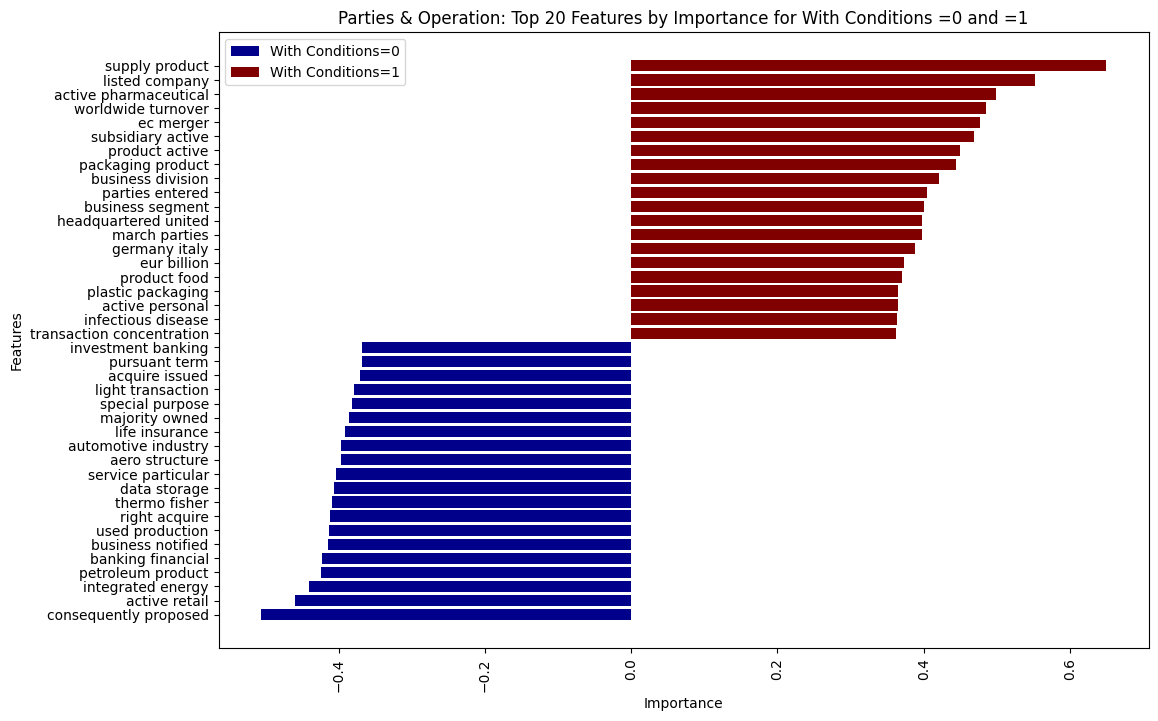

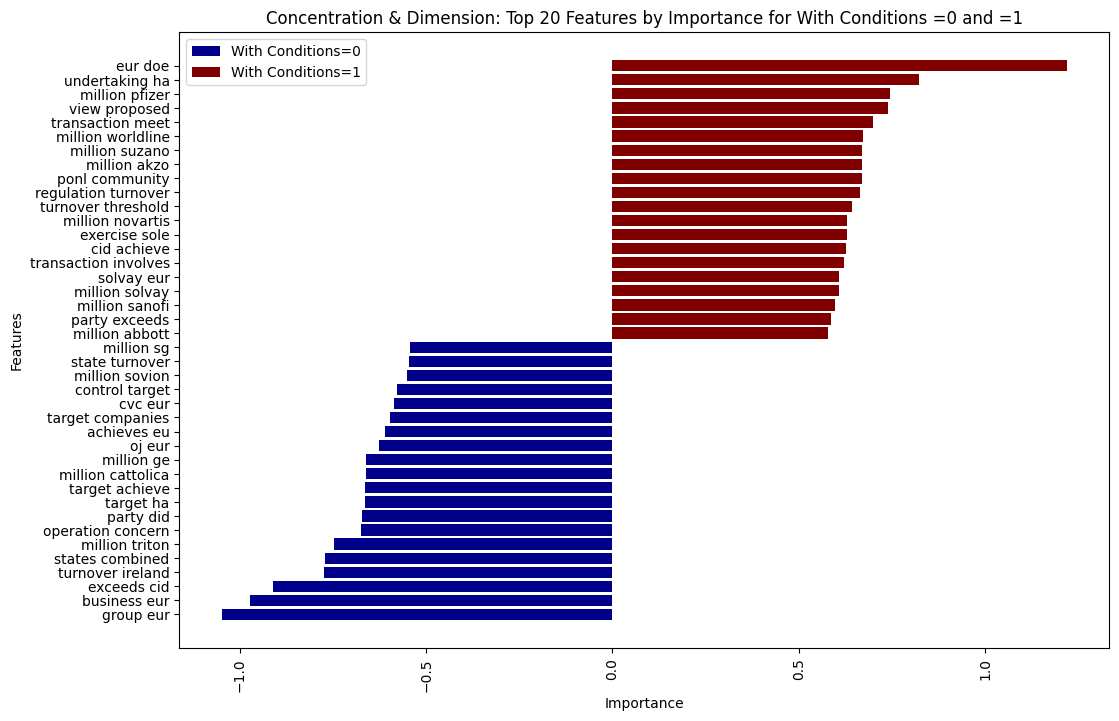

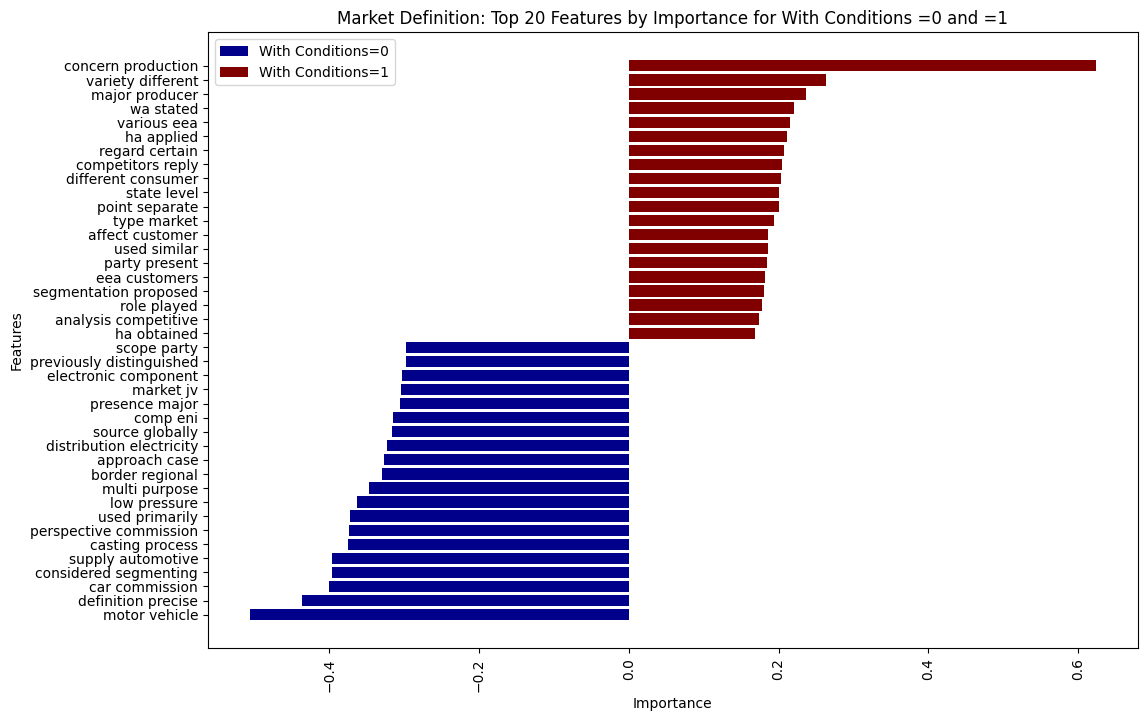

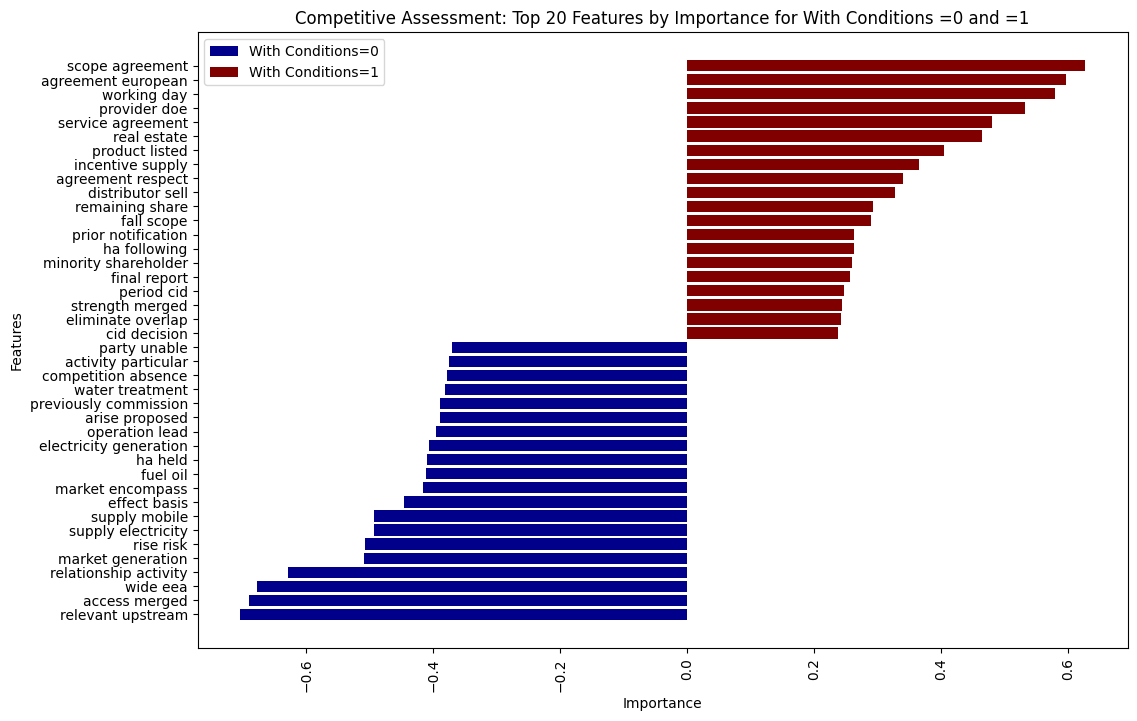

In [13]:
for section_key in section_dict.keys():
    # Sort the features by absolute importance for label=1
    globals()[f"df_features_train1_{section_key}"] = globals()[f"df_features_train1_{section_key}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train1_top10_{section_key}"] = globals()[f"df_features_train1_{section_key}"].nlargest(20, 'abs_importance')
    globals()[f"df_features_train1_top10_{section_key}"] = globals()[f"df_features_train1_top10_{section_key}"].sort_values('importance', ascending=True)

    # Sort the features by absolute importance for label=0
    globals()[f"df_features_train0_{section_key}"] = globals()[f"df_features_train0_{section_key}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train0_top10_{section_key}"] = globals()[f"df_features_train0_{section_key}"].nlargest(20, 'abs_importance')

    # Create a combined bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(globals()[f"df_features_train0_top10_{section_key}"]['feature'], globals()[f"df_features_train0_top10_{section_key}"]['importance'], color='darkblue', label='With Conditions=0')
    ax.barh(globals()[f"df_features_train1_top10_{section_key}"]['feature'], globals()[f"df_features_train1_top10_{section_key}"]['importance'], color='maroon', label='With Conditions=1')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title(str(section_dict[section_key])+ ': Top 20 Features by Importance for With Conditions =0 and =1')
    ax.legend()
    plt.xticks(rotation=90)
    #plt.show()

    plt.savefig('../../output/figures/svm_wc_section_' + str(section_key) + '.png', bbox_inches='tight')

In [14]:
for section_key in section_dict.keys():
    globals()[f"df_features_train_{section_key}"].to_excel('../../output/tables/features_svm_wc_section_' + str(section_key) + '.xlsx', index=True)